# Solving Elastic-Net problem using Proximal Gradient descent



**Problem.** In this note, we consider the so-called Elastic-Net problem

$$\min_{x\in \mathbb R^n} \quad \frac{1}{2}||b-Ax||_2^2 + \lambda_1||x||_1 + \frac{\lambda_2}{2}||x||_2^2$$

where $b\in \mathbb R^m$ and $A \in \mathbb R^{m\times n}$, $\lambda_1, \lambda_2\geq 0$. The optimal solution to this problem is sparse if $\lambda_2$ is small. In particular, the Lasso problem corresponds to $\lambda_2=0$.

**Solving method using Proximal Gradient Descent.**

The proximal gradient method is the following updating rule 

$$x^{(k+1)} = \text{prox}_{g/\alpha} \left(x^{(k)} - \frac{1}{\alpha} \nabla f(x^{(k)})\right)$$

Here $\alpha>0$ is the Lipschitz constant of the gradient of $f$ (assuming that it exists), in this case $f$ is said to be $\alpha$-smooth.

Here let's explain how such above update is a  convergence algorithm.
Note that the Elastic-Net problem is a special case of the more general form 

$$\min_{x} \quad P(x) = f(x) + g(x)$$

where $f$ is the main smooth loss function and $g$ is a regularization function which is usually non-smooth.
If one assumes that $f$ has $\alpha$-Lipschitz continuous gradient then

$$P(x') \leq f(x) + \langle \nabla f(x), x'-x\rangle +\frac{\alpha}{2} ||x'-x||^2_2 + g(x') = M(x')$$

The function $M$ is called the surrogate function of $P$ with equality if $x'=x$.
To minimize $P$ we can minimize $M$, this is known as the Majorize-Minimization method.
To do that, let us rewrite $M$,

$$M(x') = f(x)  - \frac{1}{2\alpha} ||\nabla f(x)||^2_2 + \frac{\alpha}{2} ||x' - x + \frac{1}{\alpha}\nabla f(x)||_2^2 + g(x')$$

Then, to minimize $M$ we apply the proximal operator on $g/\alpha$ with argument $x^+$,  where $x^+ = x - \frac{1}{\alpha} \nabla f(x)$ is the gradient descent update from $x$, i.e.

$$\arg\min_{x'} \quad \frac{1}{2} ||x' - x^+||_2^2 + \frac{1}{\alpha} g(x') = \text{prox}_{g/\alpha} (x^+)$$

This is exactly the proximal gradient descent method described above.

**Back to Elastic-Net problem.** For the Elastic-Net problem, we can choose $\alpha = ||A||^2_{Fro} = \sum_{i+1}^n ||a_i||_2^2$ the squared Frobenius norm, i.e. the total squared norms of $a_i$.
With $f(x) = \frac{1}{2} ||b - Ax||_2^2$, we have $\nabla f(x) = -A^T(b-Ax)$ and $g(x) = \lambda_1||x||_1 +\frac{\lambda_2}{2}||x||_2^2$. Here we compute the proximal associated with $g/\alpha$.

$$\arg\min_{x'} \quad \frac{1}{2} ||x' - x^+||_2^2 + \frac{\lambda_1}{\alpha}||x'||_1 + \frac{\lambda_2}{2\alpha} ||x'||_2^2 $$

Let $s = sign(x')$, then the Fermat's rule reads as follows 

$$x' - x^+ + \frac{\lambda_1}{\alpha} s + \frac{\lambda_2}{\alpha} x'=0 \leftrightarrow x' = \frac{\alpha}{\alpha + \lambda_2} \left[x^+ - \frac{\lambda_1}{\alpha}s\right]$$

By considering different cases of signs of $x'$ and $x^+ \pm \frac{\lambda_1}{\alpha}$, we can eliminate $s$ on the formula of $x'$ as follows 

$$ \text{prox}_{g/\alpha}(x^+) = x' = \frac{\alpha}{\alpha + \lambda_2}  \text{sign}(x^+) \left[|x^+| - \frac{\lambda_1}{\alpha}s\right]_+$$



In [41]:
import numpy as np
import matplotlib.pyplot as plt

def dic(x, t, w):
    diff = x.reshape(-1, 1) - t.reshape(1, -1) 
    g = np.power(2, -diff**2/w**2)
    norms = np.linalg.norm(g, axis=0) 
    return g/norms

def get_setup():
	np.random.seed(124)
	# Generate random A matrix of size mxn
	m, n = 30, 60 
	x_range = np.linspace(0., 1., m)
	t_range = np.linspace(0., 1., n)

	# A = np.random.rand(m, n)
	A = dic(x_range, t_range, w=0.08)

	# Generate random x0 vector of size n
	indices = [n//10, 7*(n//10), 6*(n//10)]
	x0 = np.zeros(n)
	x0[indices] = [0.4, 0.3, 0.3]

	# Compute b vector such that Ax0 = b
	b = np.dot(A, x0) + 0.05*np.random.rand(m)

	# define parameters and 
	lbd_max = np.max(np.dot(A.T, b))
	lbd = 0.3 * lbd_max  # Regularization parameter
	# rho = 0.1  # Penalty parameter
	# print(rho, lmbda)
	# max_iter = 1000
	data = {
        "x_range": x_range,
		 "t_range": t_range,
         "b": b, 
         "A": A,
         "lbd": lbd, 
         "x0": x0      
	}
	return data

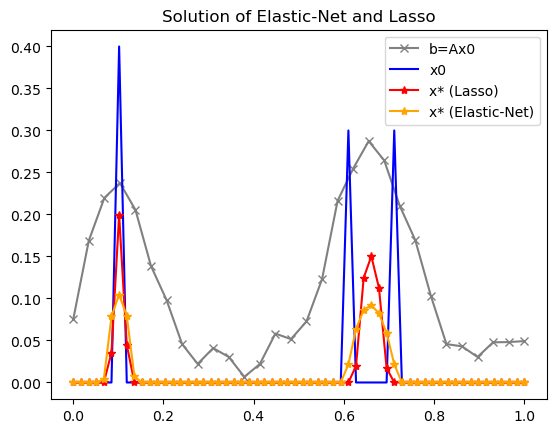

In [45]:
def pgd_elastic_net(A, b, lbd1, lbd2, max_iters=100):
    # print(A.shape, b.shape)
    _, s, _ = np.linalg.svd(A)
    L = s.max()**2 
    x = np.zeros(A.shape[1])
    x_list = []
    k1 = lbd1/L 
    k2 = L/(L+lbd2)
    for i in range(max_iters):
        x = x + (1/L) * A.T @ (b- A @ x) 
        x = k2 * np.sign(x) * (np.abs(x) - k1).clip(min=0.) 
        x_list += [x]
    # print(x.shape)
    x_list = np.vstack(x_list)
    return x_list

# 1. get data
data  = get_setup()
A = data["A"]
b = data["b"]
lbd1 = data["lbd"]
x0 = data["x0"]
x_range = data["x_range"]
t_range = data["t_range"]

# 2. solve
x_elasticnet = pgd_elastic_net(A, b, lbd1, 0., max_iters=1000)
x_lasso = pgd_elastic_net(A, b, lbd1, lbd1/2., max_iters=1000)

# 3. plot
plt.plot(x_range, b, color="gray", label="b=Ax0", marker="x")
plt.plot(t_range, x0, color="blue", label="x0")
plt.plot(t_range, x_elasticnet[-1], color="red", label="x* (Lasso)", marker="*")
plt.plot(t_range, x_lasso[-1], color="orange", label="x* (Elastic-Net)", marker="*")
plt.legend()
plt.title("Solution of Elastic-Net and Lasso")
plt.show()

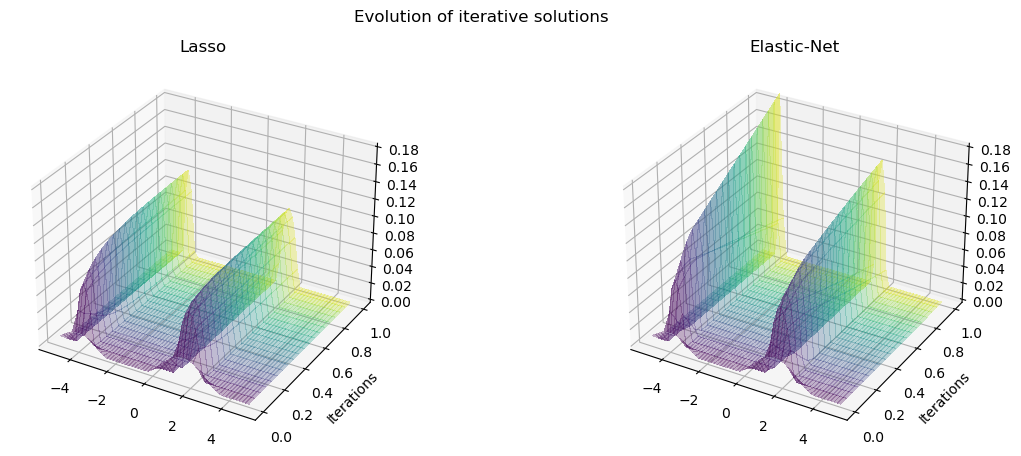

In [73]:
# Generate x and y values
k, n = x_lasso.shape
N=50
k = k//N
x = np.linspace(-5, 5, n)
y = np.linspace(0, 1, k)
X, Y = np.meshgrid(x, y)
iters = np.arange(k)*N

# Create a 3D plot
fig = plt.figure(figsize=(7*2, 5))

# 1. Lasso
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, x_lasso[iters, :], cmap='viridis', cstride=1, rstride=1,
                       linewidth=0, antialiased=False, facecolors=plt.cm.viridis(Y), alpha=0.3)
ax.set_ylabel('Iterations')
ax.set_title("Lasso")
ax.set_zlim(0., 0.18)

# 2. Elastic-Net
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, x_elasticnet[iters, :], cmap='viridis', cstride=1, rstride=1,
                       linewidth=0, antialiased=False, facecolors=plt.cm.viridis(Y), alpha=0.3)
ax.set_ylabel('Iterations')
ax.set_title("Elastic-Net")
ax.set_zlim(0., 0.18)

fig.suptitle('Evolution of iterative solutions')
plt.show()